## Business Context

With the increasing popularity and ease of access to online hotel booking platforms, customers tend to make reservations in advance to avoid any last-minute rush and higher prices. These online platforms offer flexible cancellation options, in some cases even a day before reservation. To compete with this, even offline bookings have increased the flexibility in cancellations. This has led to an increase in the growing number of cancellations, with one of the primary reasons being last-minute changes in travel plans. These sudden changes can result from unforeseen circumstances, such as personal emergencies, flight delays, or unexpected events at the travel destination.

Hotel booking cancellations become a crucial problem to solve as it leads to revenue loss and operational inefficiencies. The cancellation of bookings impacts a hotel on various fronts:

1. Loss of revenue when the hotel cannot resell the room

2. Additional costs of distribution channels by increasing commissions or paying for publicity to help sell these rooms

3. Lowering prices last minute, so the hotel can resell a room, resulting in reduced profit margins

## Problem Definition

The INN Hotels Group has been contending with the challenge of rising cancellations for nearly a year now. However, the last three months witnessed a **rise in inventory loss due to cancellation rise to an all-time high of 18%**. This has led to a jump in the **revenue loss to an all-time high of approx. \$0.25 million annually**. This has significantly impacted their profit margins.

- In the current context, inventory refers to a hotel room, and the inability to sell one leads to inventory loss

The group has been using heuristic mechanisms (rule and domain expert-based) to try and reduce the revenue loss due to cancellations, but this hasn't been effective so far hasn't been effective (neither efficient nor scalable), as evident from the magnitude of losses they are incurring.

The group has decided that they **need a Data Science-based solution to predict the likelihood of a booking being canceled** as they expect it to be more effective than their current mechanism. They hope that this proactive approach will help them significantly **minimize revenue loss and improve operational efficiency**.

In [300]:
# Import the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats

from sklearn.preprocessing import PowerTransformer

import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import (accuracy_score,confusion_matrix,roc_auc_score,roc_curve,classification_report,f1_score,recall_score,precision_score,cohen_kappa_score)
from sklearn.model_selection import GridSearchCV

### Load the Past Data and New Data

In [301]:
past_data = pd.read_csv(r"C:\Users\Soumik Ghosh\Desktop\great lakes\machine learning\data for hotels\INNHotelsGroup_pastdata.csv")
new_data  = pd.read_csv(r"C:\Users\Soumik Ghosh\Desktop\great lakes\machine learning\data for hotels\INNHotelsGroup_newdata.csv")

In [302]:
# Lets check their shape
past_data.shape

(27093, 12)

In [303]:
new_data.shape

(3583, 11)

In [304]:
past_data.head(2)

,booking_id,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status,rebooked
0,INNHG_101034,0,Online,0,85.03,1,1,2021-01-01,0,0,Not Canceled,NaN
1,INNHG_101035,34,Online,2,125.10,2,2,2021-01-01,0,0,Not Canceled,NaN


In [305]:
past_data.tail(2)

,booking_id,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status,rebooked
27091,INNHG_128125,68,Online,1,131.40,2,0,2022-06-30,0,2,Canceled,No
27092,INNHG_128126,158,Online,1,90.95,2,1,2022-06-30,0,3,Canceled,No


In [306]:
new_data.head(2)

,booking_id,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status
0,INNHG_128127,4,Online,1,103.0,1,0,2022-07-01,1,1,Not Canceled
1,INNHG_128128,147,Online,2,103.7,2,2,2022-07-01,0,2,Not Canceled


#### Lets Understand exactly how many bookings were cancelled and rebooked at last moment from JAN-21 to JULY-22

In [307]:
# Lets see how many bookings were cancelled

In [308]:
past_data['booking_status'].value_counts(normalize=True)

booking_status
Not Canceled    0.673089
Canceled        0.326911
Name: proportion, dtype: float64

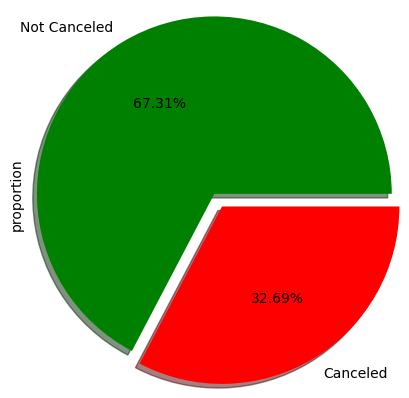

In [309]:
past_data['booking_status'].value_counts(normalize=True).plot(kind='pie',
                                    autopct='%.2f%%',radius=1.2,colors=['green','red'],
                                    shadow=True,explode=[0,0.1])
plt.show()

In [310]:
# Lets see how many cancelled bookings were rebooked?

book_data = past_data[past_data['booking_status']=='Canceled']

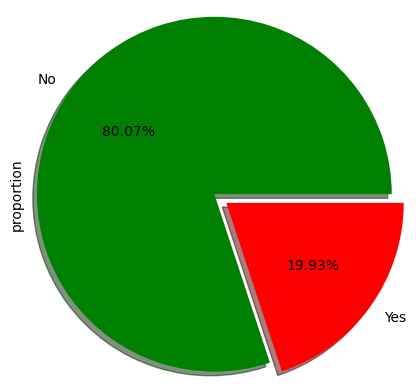

In [311]:
book_data['rebooked'].value_counts(normalize=True).plot(kind='pie',
                                    autopct='%.2f%%',radius=1.2,colors=['green','red'],
                                    shadow=True,explode=[0,0.1])
plt.show()

Inference: Here we can see that out of all the booking ~33% bookings are being cancelled and out of these 33% only ~20% booking are rebooked. Hence the Heuristic approach is not affective at all, the inventory losses are still very high.

## Exploring the data

In [312]:
past_data.head(2)

,booking_id,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status,rebooked
0,INNHG_101034,0,Online,0,85.03,1,1,2021-01-01,0,0,Not Canceled,NaN
1,INNHG_101035,34,Online,2,125.10,2,2,2021-01-01,0,0,Not Canceled,NaN


In [313]:
past_data.describe().T

,count,mean,std,min,25%,50%,75%,max
lead_time,27093.0,81.605249,84.901428,0.0,14.0,55.0,118.0,443.0
no_of_special_requests,27093.0,0.556454,0.743715,0.0,0.0,0.0,1.0,5.0
avg_price_per_room,27093.0,101.025910,34.557289,0.0,79.0,97.0,119.0,540.0
no_of_adults,27093.0,1.825822,0.512182,0.0,2.0,2.0,2.0,4.0
no_of_weekend_nights,27093.0,0.778319,0.861787,0.0,0.0,1.0,1.0,6.0
required_car_parking_space,27093.0,0.028864,0.167426,0.0,0.0,0.0,0.0,1.0
no_of_week_nights,27093.0,2.171373,1.386023,0.0,1.0,2.0,3.0,17.0


In [314]:
# Booking is a redundant column lets make it an index.

past_data.set_index('booking_id',inplace=True)
new_data.set_index('booking_id',inplace=True)

In [315]:
# We also need to change the data type of columns "Arrival Date" to datetime
past_data['arrival_date'] = pd.to_datetime(past_data['arrival_date'],format='%Y-%m-%d')
new_data['arrival_date'] = pd.to_datetime(new_data['arrival_date'],format='%Y-%m-%d')

In [316]:
past_data.dtypes

lead_time                              int64
market_segment_type                   object
no_of_special_requests                 int64
avg_price_per_room                   float64
no_of_adults                           int64
no_of_weekend_nights                   int64
arrival_date                  datetime64[ns]
required_car_parking_space             int64
no_of_week_nights                      int64
booking_status                        object
rebooked                              object
dtype: object

In [317]:
past_data.tail(2)

,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status,rebooked
booking_id,,,,,,,,,,,
INNHG_128125,68,Online,1,131.40,2,0,2022-06-30,0,2,Canceled,No
INNHG_128126,158,Online,1,90.95,2,1,2022-06-30,0,3,Canceled,No


### Univariate Analysis 

In [318]:
num_cols = ['lead_time','avg_price_per_room']
cat_cols = ['market_segment_type', 'no_of_special_requests',
            'no_of_adults', 'no_of_weekend_nights','required_car_parking_space', 
            'no_of_week_nights','booking_status', 'rebooked']

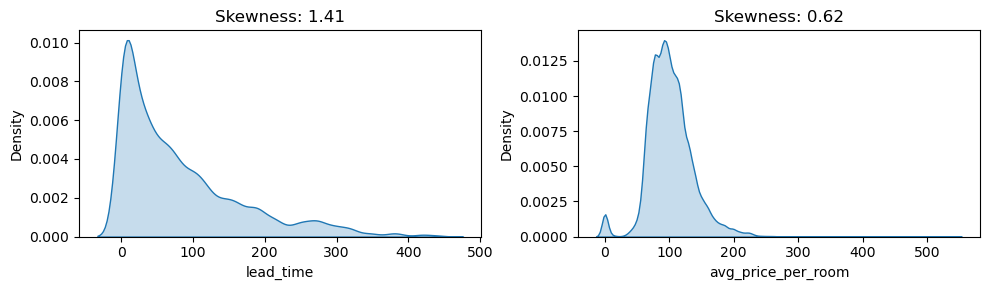

In [319]:
t=1
plt.figure(figsize=(10,3))
for i in num_cols:
    plt.subplot(1,2,t)
    sns.kdeplot(data=past_data,x=i,fill=True)
    plt.title(f'Skewness: {round(past_data[i].skew(),2)}')
    t+=1
plt.tight_layout()
plt.show()
    

Inference:
* The lead time has very large values >200, which means there are bookings which have been made more than 200 days prior !!!
* There are booking with average price per room is 0?

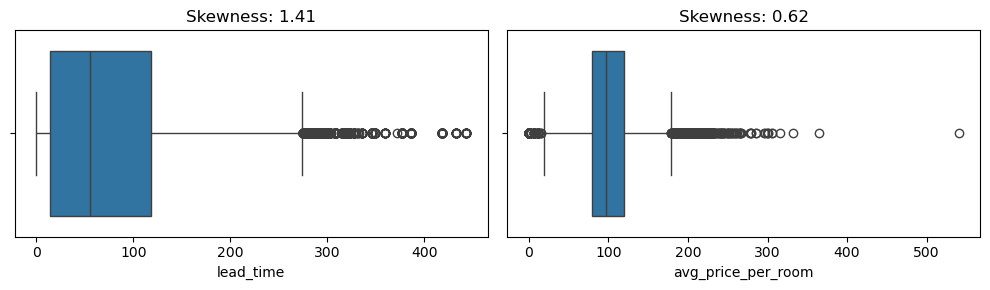

In [320]:
t=1
plt.figure(figsize=(10,3))
for i in num_cols:
    plt.subplot(1,2,t)
    sns.boxplot(data=past_data,x=i)
    plt.title(f'Skewness: {round(past_data[i].skew(),2)}')
    t+=1
plt.tight_layout()
plt.show()

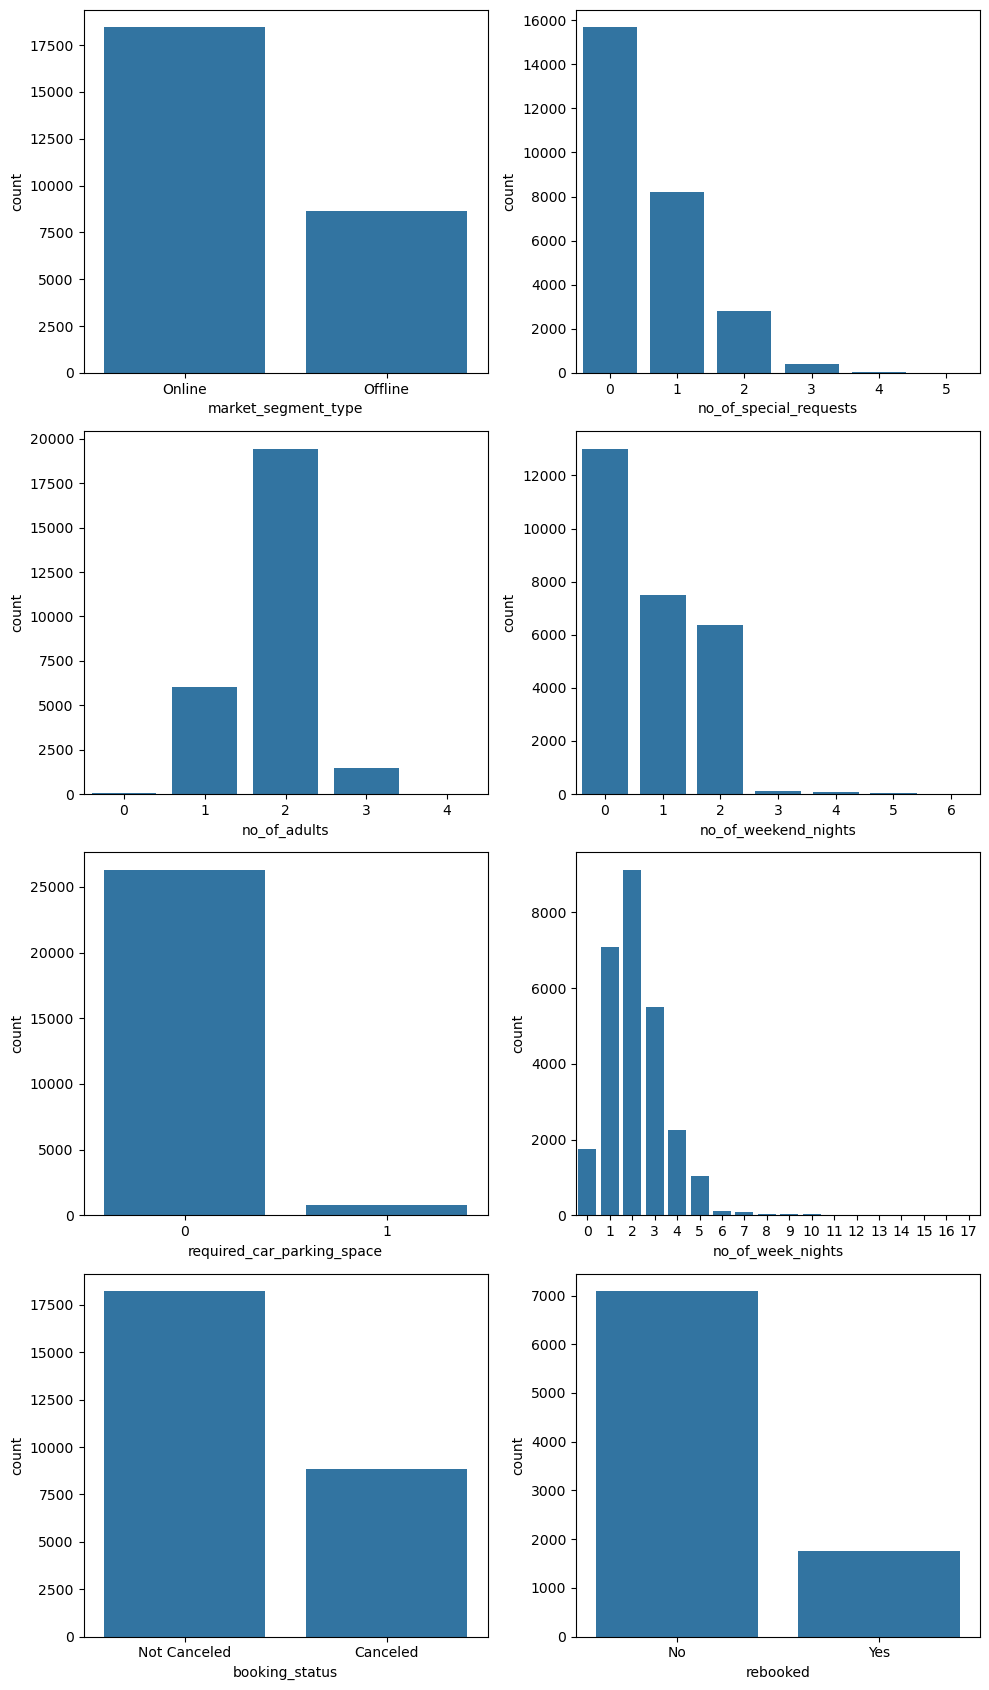

In [321]:
t=1
plt.figure(figsize=(10,17))
for i in cat_cols:
    plt.subplot(4,2,t)
    sns.countplot(data=past_data,x=i)
    t+=1
plt.tight_layout()
plt.show()

Inference:

*

*

*

### Bivariate Analysis

In [322]:
# Num VS Cat

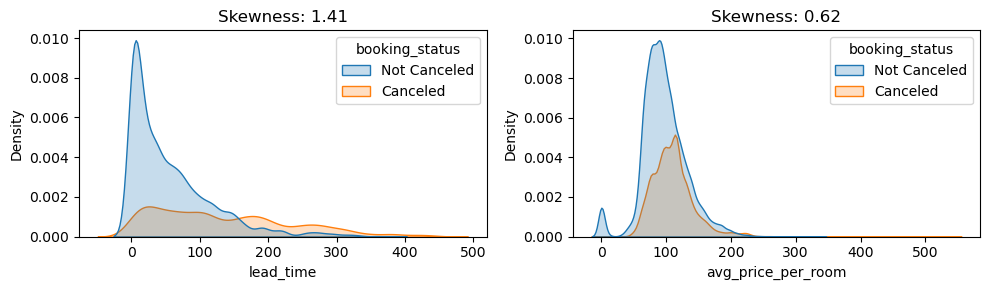

In [323]:
t=1
plt.figure(figsize=(10,3))
for i in num_cols:
    plt.subplot(1,2,t)
    sns.kdeplot(data=past_data,x=i,fill=True,hue='booking_status')
    plt.title(f'Skewness: {round(past_data[i].skew(),2)}')
    t+=1
plt.tight_layout()
plt.show()

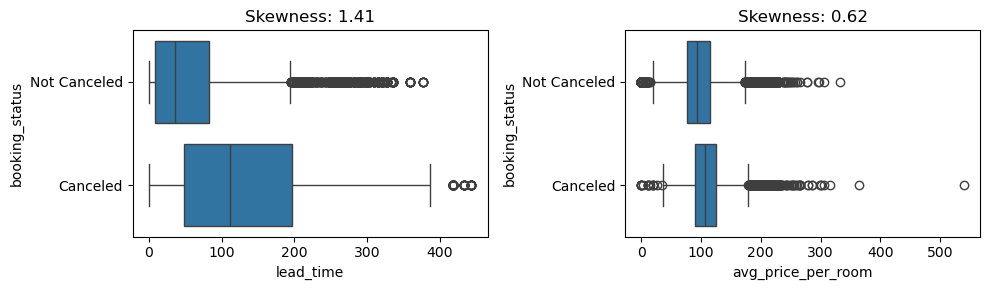

In [324]:
t=1
plt.figure(figsize=(10,3))
for i in num_cols:
    plt.subplot(1,2,t)
    sns.boxplot(data=past_data,x=i,y='booking_status')
    plt.title(f'Skewness: {round(past_data[i].skew(),2)}')
    t+=1
plt.tight_layout()
plt.show()

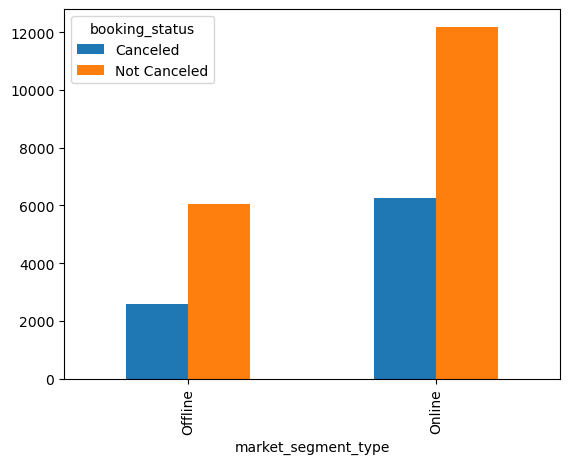

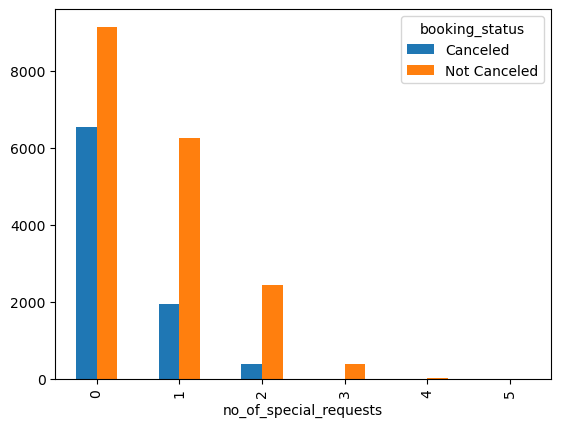

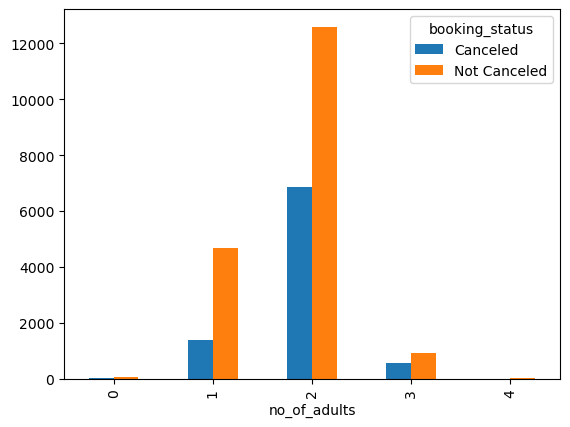

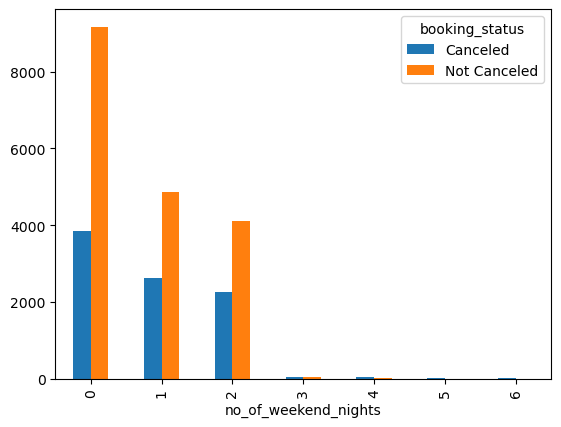

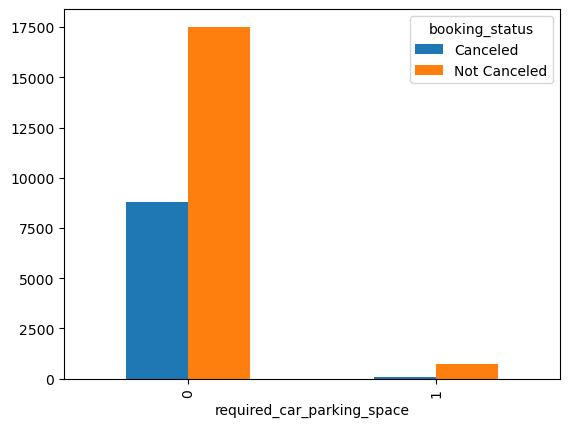

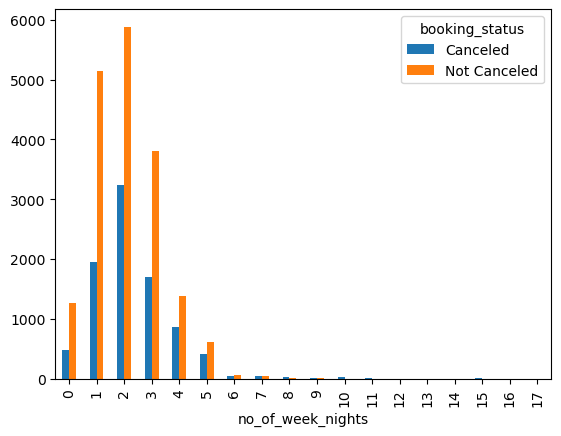

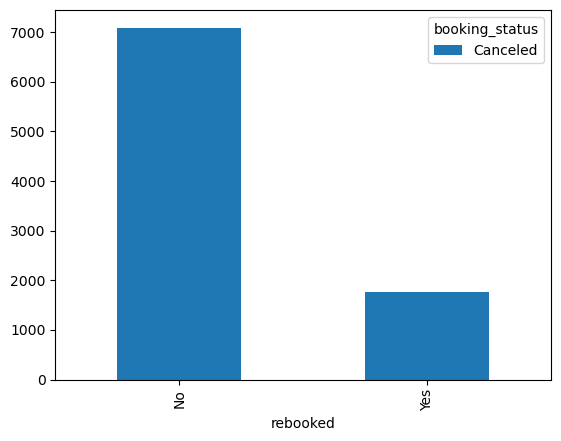

In [325]:
# Cat vs Cat (Grouped Bar plot)

for i in cat_cols:
    if i !='booking_status':
        pd.crosstab(past_data[i],past_data['booking_status']).plot(kind='bar')
    plt.show()

### Multivariate Analysis

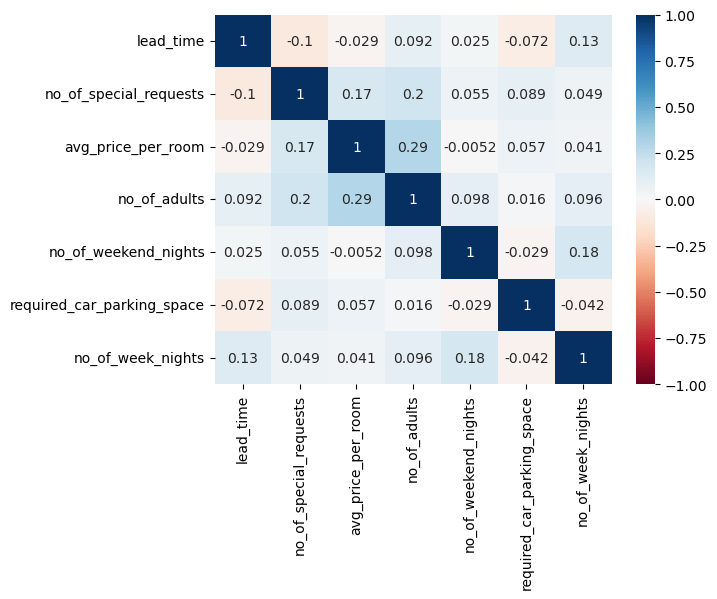

In [326]:
sns.heatmap(past_data.corr(numeric_only=True),annot=True,cmap='RdBu',vmin=-1)
plt.show()

## Inferential Statistics

In [327]:
# Lets statistically test the inferences that we have made.

In [328]:
# Lead_time vs Booking Status

samp1 = past_data[past_data['booking_status']=='Canceled']['lead_time']
samp2 = past_data[past_data['booking_status']=='Not Canceled']['lead_time']

# Lets go with 2 Sample t-test
# Ho: mu1=mu2 (Lead time does not affects the booking cancelations)
# Ha: mu1!=mu2 (Lead time does affects the booking cancelations)


# Assumption 1: data must be normal (Since sample size>30 lets assume it normal)

# Assumption 2: variances must be equal
# Ho: Variances are equal
# Ha: Variances are not equal
print(stats.levene(samp1,samp2))  #p_value less than 0.05

# Hence varainces of pop are not equal hence lets go with two sample t-test
# with unequal varainces (Welch's t-test)

print(stats.ttest_ind(samp1,samp2,equal_var=False))
# Since p_value is <0.05 we reject Ho:

LeveneResult(statistic=3210.120590252021, pvalue=0.0)
TtestResult(statistic=66.84799194126163, pvalue=0.0, df=12138.394836237343)


In [329]:
# Avg_room_price VS booking_status

samp1 = past_data[past_data['booking_status']=='Canceled']['avg_price_per_room']
samp2 = past_data[past_data['booking_status']=='Not Canceled']['avg_price_per_room']

# Lets go with 2 Sample t-test
# Ho: mu1=mu2 (avg_price_per_room does not affects the booking status)
# Ha: mu1!=mu2 (avg_price_per_room does affects the booking status)


# Assumption 1: data must be normal (Since sample size>30 lets assume it normal)

# Assumption 2: variances must be equal
# Ho: Variances are equal
# Ha: Variances are not equal
print(stats.levene(samp1,samp2))  #p_value less than 0.05

# Hence varainces of pop are not equal hence lets go with two sample t-test
# with unequal varainces (Welch's t-test)

print(stats.ttest_ind(samp1,samp2,equal_var=False))
# Since p_value is <0.05 we reject Ho:

LeveneResult(statistic=29.227364523829735, pvalue=6.490728476679038e-08)
TtestResult(statistic=29.9727805387597, pvalue=8.462441935004689e-193, df=18575.27155776574)


In [330]:
# All cat columns VS booking status

# chi-square test for independence

# Ho: No relation in categories
# Ha: There is relation in categories

for i in cat_cols:
    if i not in ['booking_status','rebooked']:
        ct = pd.crosstab(past_data['booking_status'],past_data[i])
        print(i,':\t',stats.chi2_contingency(ct)[1])
        
# Since p-values for all the category columns are less than 0.05,
# all the cat columns are statistically significant

market_segment_type :	 7.806389643886697e-11
no_of_special_requests :	 0.0
no_of_adults :	 1.441185511500568e-73
no_of_weekend_nights :	 5.324997086476798e-43
required_car_parking_space :	 5.626905783478662e-49
no_of_week_nights :	 7.318602549508705e-65


## Data Preprocessing

In [331]:
# Lets remove the "rebooked" from the predictive modelling as this info
# will not be available for future data

In [332]:
past_data.drop(columns=['rebooked'],inplace=True)

In [333]:
past_data.head(2)

,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status
booking_id,,,,,,,,,,
INNHG_101034,0,Online,0,85.03,1,1,2021-01-01,0,0,Not Canceled
INNHG_101035,34,Online,2,125.10,2,2,2021-01-01,0,0,Not Canceled


### Missing Values

In [334]:
past_data.isnull().sum()

lead_time                     0
market_segment_type           0
no_of_special_requests        0
avg_price_per_room            0
no_of_adults                  0
no_of_weekend_nights          0
arrival_date                  0
required_car_parking_space    0
no_of_week_nights             0
booking_status                0
dtype: int64

In [335]:
new_data.isnull().sum()

lead_time                     0
market_segment_type           0
no_of_special_requests        0
avg_price_per_room            0
no_of_adults                  0
no_of_weekend_nights          0
arrival_date                  0
required_car_parking_space    0
no_of_week_nights             0
booking_status                0
dtype: int64

### Outlier Treatment

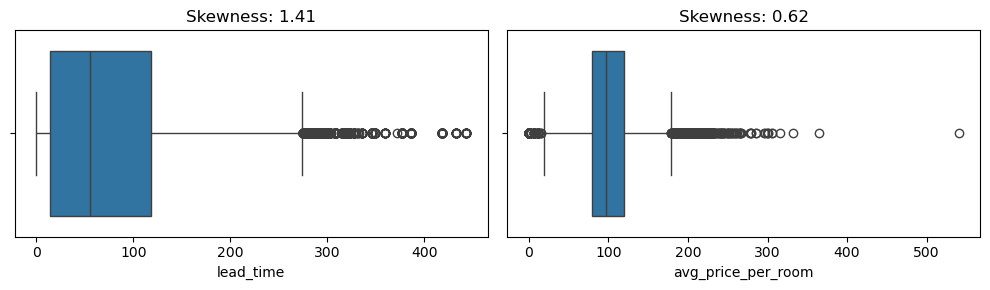

In [336]:
t=1
plt.figure(figsize=(10,3))
for i in num_cols:
    plt.subplot(1,2,t)
    sns.boxplot(data=past_data,x=i)
    plt.title(f'Skewness: {round(past_data[i].skew(),2)}')
    t+=1
plt.tight_layout()
plt.show()

In [337]:
# Lets cap the extreme outliers
for i in num_cols:
    q1,q3 = np.quantile(past_data[i],[0.25,0.75])
    iqr = q3-q1
    ul,ll = q3+2.5*iqr,q1-2.5*iqr
    past_data[i]=past_data[i].apply(lambda x: ul if x>ul else 
                                    ll if x<ll else x)

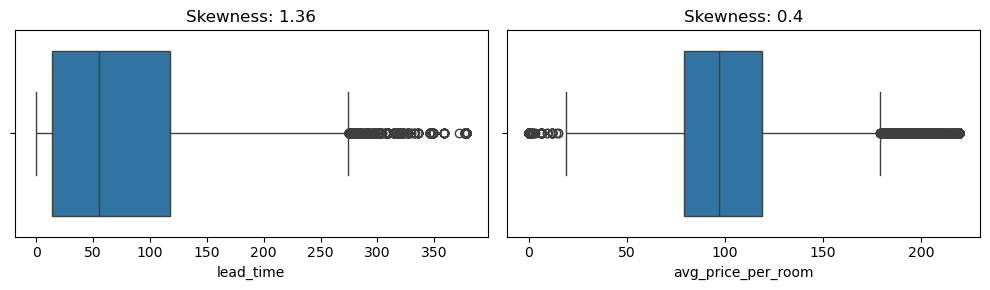

In [338]:
t=1
plt.figure(figsize=(10,3))
for i in num_cols:
    plt.subplot(1,2,t)
    sns.boxplot(data=past_data,x=i)
    plt.title(f'Skewness: {round(past_data[i].skew(),2)}')
    t+=1
plt.tight_layout()
plt.show()

### Feature Encoding

In [339]:
past_data = pd.get_dummies(past_data,columns=['market_segment_type'],drop_first=True,dtype=int)

In [340]:
new_data = pd.get_dummies(new_data,columns=['market_segment_type'],drop_first=True,dtype=int)

In [341]:
# Let do ordinal encoding for booking status

past_data['booking_status'] = past_data['booking_status'].map({'Canceled':1,
                                                              'Not Canceled':0})

In [342]:
new_data['booking_status'] = new_data['booking_status'].map({'Canceled':1,
                                                              'Not Canceled':0})

In [343]:
new_data.head(2)

,lead_time,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status,market_segment_type_Online
booking_id,,,,,,,,,,
INNHG_128127,4,1,103.0,1,0,2022-07-01,1,1,0,1
INNHG_128128,147,2,103.7,2,2,2022-07-01,0,2,0,1


### Feature Transformation

In [344]:
transformer = PowerTransformer(standardize=False)

In [345]:
past_data[num_cols] = transformer.fit_transform(past_data[num_cols])
new_data[num_cols] = transformer.transform(new_data[num_cols])

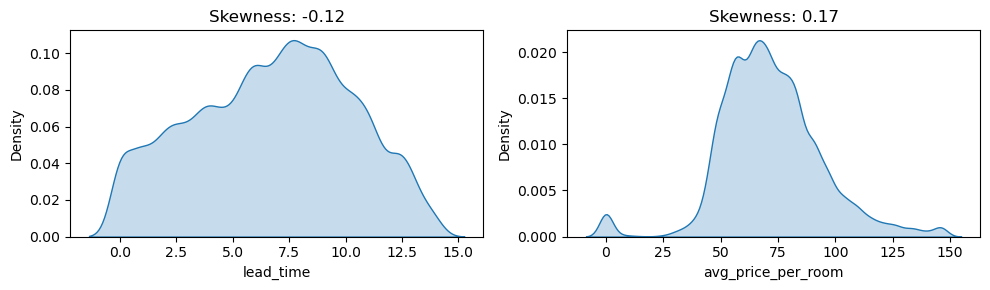

In [346]:
t=1
plt.figure(figsize=(10,3))
for i in num_cols:
    plt.subplot(1,2,t)
    sns.kdeplot(data=past_data,x=i,fill=True)
    plt.title(f'Skewness: {round(past_data[i].skew(),2)}')
    t+=1
plt.tight_layout()
plt.show()

### Feature Engineering (Generate new columns)

In [347]:
# Lets extract month and weekday from date of arrival
past_data['arrival_month']=past_data['arrival_date'].dt.month
past_data['arrival_wkday']=past_data['arrival_date'].dt.weekday

In [348]:
past_data.drop(columns='arrival_date',inplace=True)
past_data.head(2)

,lead_time,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,required_car_parking_space,no_of_week_nights,booking_status,market_segment_type_Online,arrival_month,arrival_wkday
booking_id,,,,,,,,,,,
INNHG_101034,0.00000,0,61.729381,1,1,0,0,0,1,1,4
INNHG_101035,5.78447,2,87.801167,2,2,0,0,0,1,1,4


In [349]:
new_data['arrival_month']=new_data['arrival_date'].dt.month
new_data['arrival_wkday']=new_data['arrival_date'].dt.weekday
new_data.drop(columns='arrival_date',inplace=True)

In [350]:
new_data.head(2)

,lead_time,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,required_car_parking_space,no_of_week_nights,booking_status,market_segment_type_Online,arrival_month,arrival_wkday
booking_id,,,,,,,,,,,
INNHG_128127,1.989422,1,73.535594,1,0,1,1,0,1,7,4
INNHG_128128,10.093647,2,73.991462,2,2,0,2,0,1,7,4


In [351]:
# We can add no of weekdays and weekdn in the booking and get stay duration
past_data['total_nights'] = past_data['no_of_week_nights'] + past_data['no_of_weekend_nights']

In [352]:
new_data['total_nights'] = new_data['no_of_week_nights'] + new_data['no_of_weekend_nights']

In [353]:
past_data.head(2)

,lead_time,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,required_car_parking_space,no_of_week_nights,booking_status,market_segment_type_Online,arrival_month,arrival_wkday,total_nights
booking_id,,,,,,,,,,,,
INNHG_101034,0.00000,0,61.729381,1,1,0,0,0,1,1,4,1
INNHG_101035,5.78447,2,87.801167,2,2,0,0,0,1,1,4,2


In [354]:
new_data.head(2)

,lead_time,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,required_car_parking_space,no_of_week_nights,booking_status,market_segment_type_Online,arrival_month,arrival_wkday,total_nights
booking_id,,,,,,,,,,,,
INNHG_128127,1.989422,1,73.535594,1,0,1,1,0,1,7,4,1
INNHG_128128,10.093647,2,73.991462,2,2,0,2,0,1,7,4,4


In [355]:
# We can also calculate the departure weekday from total nights and arrival 
# weekday

In [356]:
past_data['depart_wkday'] = past_data['arrival_wkday']+past_data['total_nights']

In [357]:
new_data['depart_wkday'] = new_data['arrival_wkday']+new_data['total_nights']

In [358]:
def setting_weekday(num):
    if num>6:
        return num%7
    else:
        return num

In [359]:
past_data['depart_wkday'] = past_data['depart_wkday'].apply(setting_weekday)
new_data['depart_wkday'] = new_data['depart_wkday'].apply(setting_weekday)

In [360]:
past_data.head()

,lead_time,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,required_car_parking_space,no_of_week_nights,booking_status,market_segment_type_Online,arrival_month,arrival_wkday,total_nights,depart_wkday
booking_id,,,,,,,,,,,,,
INNHG_101034,0.000000,0,61.729381,1,1,0,0,0,1,1,4,1,5
INNHG_101035,5.784470,2,87.801167,2,2,0,0,0,1,1,4,2,6
INNHG_101036,4.986923,1,52.818520,2,2,0,0,0,1,1,4,2,6
INNHG_101037,4.894729,0,61.510571,1,2,0,0,0,1,1,4,2,6
INNHG_101038,6.541683,1,103.222808,2,2,0,3,1,1,1,4,5,2


In [361]:
past_data.shape

(27093, 13)

In [362]:
new_data.shape

(3583, 13)

# Predictive Modeling

In [363]:
y_train = past_data['booking_status']
x_train = past_data.drop(columns=['booking_status'])
x_test = new_data.drop(columns=['booking_status'])
y_test = new_data['booking_status']

In [364]:
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(27093, 12) (27093,) (3583, 12) (3583,)


In [365]:
# create function to train predict and validate the models.
def model_training(model,xtrain=x_train,ytrain=y_train,xtest=x_test,cutoff = 0.5):
    m = model
    m.fit(xtrain,ytrain)
    pred_s = m.predict_proba(xtest)[:,1]
    pred_h = (pred_s>cutoff).astype(int)
    return pred_s,pred_h


In [366]:
def model_scores(predh,preds,ytest = y_test):
    
    print('\nConfusion Matrix:\n',confusion_matrix(ytest,predh))
    print('\nClassification Report:\n',classification_report(ytest,predh))
    fpr,tpr,thresholds = roc_curve(ytest,preds)
    plt.plot(fpr,tpr)
    plt.plot([0,1],[0,1],ls = '--', color = 'red')
    plt.title(f'ROC AUC Curve:{round(roc_auc_score(ytest,preds),2)}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

In [367]:
def model_tuning(model,grid,x=x_train,y=y_train,folds = 6,score='roc_auc'):
    gscv = GridSearchCV(estimator=model,
                      param_grid=grid,
                      scoring=score,
                      cv=folds,
                      
                      verbose=0)
    gscv.fit(x,y)
    print('Best Score:',gscv.best_score_)
    return gscv.best_params_
    return gscv.best_estimator_

In [368]:
# function for scorecard


In [369]:
mod = []
accu = []
rec = []
pre = []
f1 =  []
ck = []
auc = []
def model_scorecard(model_name,predh,preds,ytest = y_test):
    mod.append(model_name)
    accu.append(accuracy_score(ytest,predh))
    auc.append(roc_auc_score(ytest,preds))
    f1.append(f1_score(ytest,predh))
    pre.append(precision_score(ytest,predh))
    rec.append(recall_score(ytest,predh))
    ck.append(cohen_kappa_score(ytest,predh))
    auc.append(roc_auc_score(ytest,preds))
    global scorecard 
    scorecard = pd.DataFrame({'Accuracy':accu,
                              'Recall':rec,
                              'Precision':pre,
                              'F1 Score':f1,
                              'Cohen Kappa':ck,
                              'ROC AUC':auc},index = mod)
    return scorecard

In [380]:
mod = []
accu = []
rec = []
pre = []
f1 = []
ck = []
auc = []

def model_scorecard(model_name, predh, preds, ytest=y_test):
    # Append model name
    mod.append(model_name)
    
    # Append metrics
    accu.append(accuracy_score(ytest, predh))
    rec.append(recall_score(ytest, predh))
    pre.append(precision_score(ytest, predh))
    f1.append(f1_score(ytest, predh))
    ck.append(cohen_kappa_score(ytest, predh))
    auc.append(roc_auc_score(ytest, preds))   # append only once
    
    # Create DataFrame
    global scorecard
    scorecard = pd.DataFrame({
        'Accuracy': accu,
        'Recall': rec,
        'Precision': pre,
        'F1 Score': f1,
        'Cohen Kappa': ck,
        'ROC AUC': auc
    }, index=mod)
    
    return scorecard


In [370]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier

In [371]:
model_training(LogisticRegression())

(array([0.02425449, 0.12572355, 0.1070463 , ..., 0.1354897 , 0.81915433,
        0.39293467]),
 array([0, 0, 0, ..., 0, 1, 0]))

In [372]:
ypred_lr_s,ypred_lr_h = model_training(LogisticRegression())


Confusion Matrix:
 [[2216  167]
 [ 574  626]]

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.93      0.86      2383
           1       0.79      0.52      0.63      1200

    accuracy                           0.79      3583
   macro avg       0.79      0.73      0.74      3583
weighted avg       0.79      0.79      0.78      3583



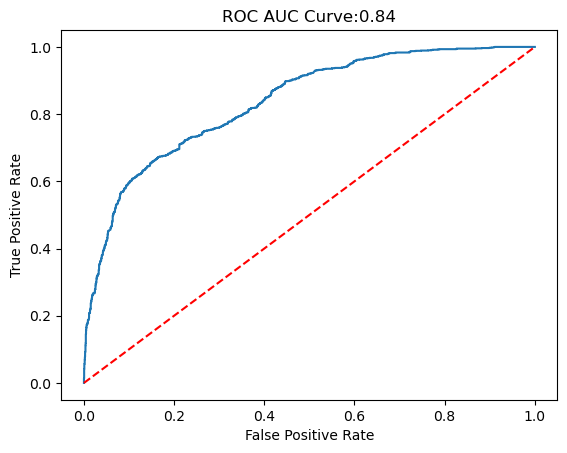

In [373]:
model_scores(ypred_lr_h,ypred_lr_s )

In [374]:
import matplotlib.pyplot as plot

In [381]:
model_scorecard('LOG REG (Base Model)',ypred_lr_h,ypred_lr_s )

,Accuracy,Recall,Precision,F1 Score,Cohen Kappa,ROC AUC
LOG REG (Base Model),0.79319,0.521667,0.789407,0.628199,0.493099,0.836566


In [ ]:
# Decision Tree
grid = {'max_depth':[4,5,6,7,8]}
best_params = model_tuning(DecisionTreeClassifier(class_weight='balanced'),grid)

Best Score: 0.7655998334641763


In [ ]:
ypred_dt_s,ypred_dt_h = model_training(DecisionTreeClassifier(class_weight='balanced',**best_params))


Confusion Matrix:
 [[2106  277]
 [ 360  840]]

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.88      0.87      2383
           1       0.75      0.70      0.73      1200

    accuracy                           0.82      3583
   macro avg       0.80      0.79      0.80      3583
weighted avg       0.82      0.82      0.82      3583



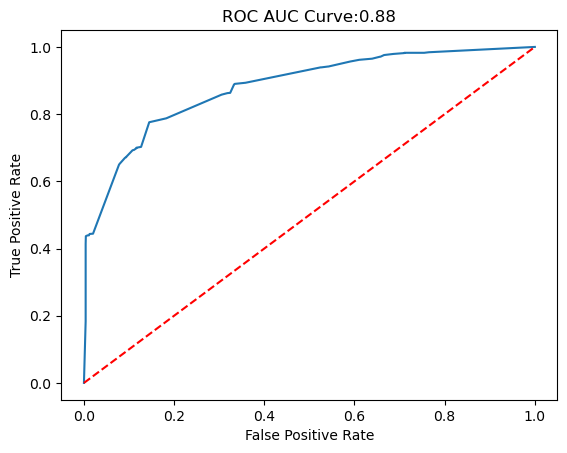

In [ ]:
model_scores(ypred_dt_h,ypred_dt_s)

In [382]:
scorecard

,Accuracy,Recall,Precision,F1 Score,Cohen Kappa,ROC AUC
LOG REG (Base Model),0.79319,0.521667,0.789407,0.628199,0.493099,0.836566


In [383]:
model_scorecard('Decision Tree',ypred_dt_h,ypred_dt_s)

,Accuracy,Recall,Precision,F1 Score,Cohen Kappa,ROC AUC
LOG REG (Base Model),0.793190,0.521667,0.789407,0.628199,0.493099,0.836566
Decision Tree,0.822216,0.700000,0.752014,0.725076,0.593957,0.880697


In [376]:
# Random Forest (Bagging Technique)
grid = {'n_estimators':[70,100,120,150,180,200],
        'max_depth':[3,4,5,6]}
best_params = model_tuning(RandomForestClassifier(class_weight='balanced'),grid)

Best Score: 0.8122651001323864


In [ ]:
ypred_rf_s,ypred_rf_h = model_training(RandomForestClassifier(class_weight='balanced',**best_params))


Confusion Matrix:
 [[2027  356]
 [ 405  795]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.85      0.84      2383
           1       0.69      0.66      0.68      1200

    accuracy                           0.79      3583
   macro avg       0.76      0.76      0.76      3583
weighted avg       0.79      0.79      0.79      3583



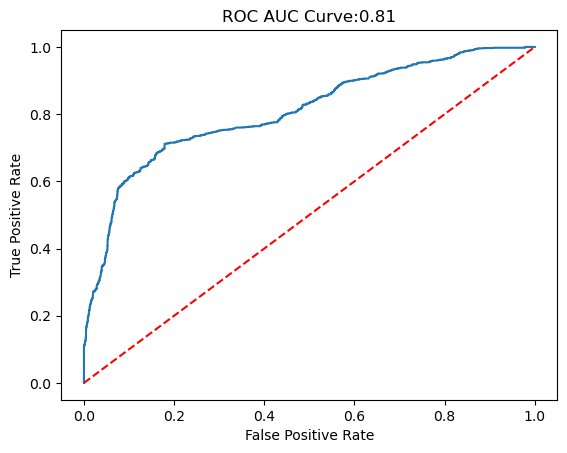

In [378]:
model_scores(ypred_rf_h,ypred_rf_s)

In [384]:
model_scorecard('Random Forest',ypred_rf_h,ypred_rf_s)

,Accuracy,Recall,Precision,F1 Score,Cohen Kappa,ROC AUC
LOG REG (Base Model),0.793190,0.521667,0.789407,0.628199,0.493099,0.836566
Decision Tree,0.822216,0.700000,0.752014,0.725076,0.593957,0.880697
Random Forest,0.787608,0.662500,0.690704,0.676308,0.518362,0.808169


In [386]:
# XGBOOST (Boosting Technique)
grid = {'gamma':[2,3,4,5],
        'learning_rate':[0.01,0.1,0.2,0.5]}

In [387]:
model_tuning(XGBClassifier(class_weights='balanced'),grid)

Best Score: 0.7767901328039207


{'gamma': 4, 'learning_rate': 0.01}

In [396]:
grid1 = {'max_depth':[2,3,4,5],'n_estimators':[100,150,200,250],
        'learning_rate':[0.01,0.02,0.05,0.1]}

In [397]:
best_params = model_tuning(XGBClassifier(class_weights='balanced'),grid1)

Best Score: 0.7759322168251893


In [398]:
ypred_xgb_s,ypred_xgb_h = model_training(XGBClassifier(class_weights='balanced',**best_params))


Confusion Matrix:
 [[2148  235]
 [ 398  802]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87      2383
           1       0.77      0.67      0.72      1200

    accuracy                           0.82      3583
   macro avg       0.81      0.78      0.79      3583
weighted avg       0.82      0.82      0.82      3583



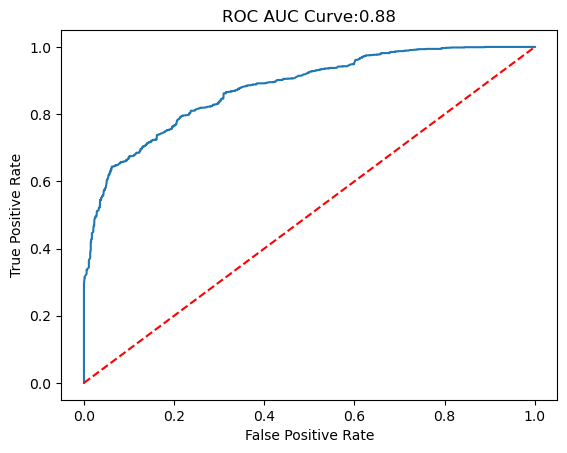

In [399]:
model_scores(ypred_xgb_h,ypred_xgb_s)

In [402]:
model_scorecard('XG BOOST2',ypred_xgb_h,ypred_xgb_s)

,Accuracy,Recall,Precision,F1 Score,Cohen Kappa,ROC AUC
LOG REG (Base Model),0.793190,0.521667,0.789407,0.628199,0.493099,0.836566
Decision Tree,0.822216,0.700000,0.752014,0.725076,0.593957,0.880697
Random Forest,0.787608,0.662500,0.690704,0.676308,0.518362,0.808169
XG BOOST,0.817192,0.646667,0.770606,0.703217,0.572589,0.868090
XG BOOST,0.823332,0.668333,0.773385,0.717032,0.589597,0.876986
XG BOOST2,0.823332,0.668333,0.773385,0.717032,0.589597,0.876986


In [401]:
best_params

{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 150}

In [405]:
# Final Model 
# Lets explore XGBOOST 
model_xgb = XGBClassifier(n_estimators=100,learning_rate = 0.01,max_depth = 7)


Confusion Matrix:
 [[17402   834]
 [ 2981  5876]]

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.95      0.90     18236
           1       0.88      0.66      0.75      8857

    accuracy                           0.86     27093
   macro avg       0.86      0.81      0.83     27093
weighted avg       0.86      0.86      0.85     27093



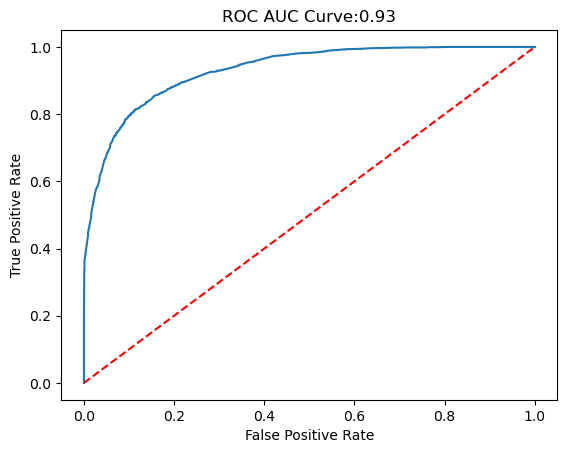

In [408]:
# train score 
ypred_xgb_s,ypred_xgb_h = model_training(model_xgb,xtest=x_train)
model_scores(ypred_xgb_h,ypred_xgb_s,ytest=y_train)


Confusion Matrix:
 [[2239  144]
 [ 435  765]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.94      0.89      2383
           1       0.84      0.64      0.73      1200

    accuracy                           0.84      3583
   macro avg       0.84      0.79      0.81      3583
weighted avg       0.84      0.84      0.83      3583



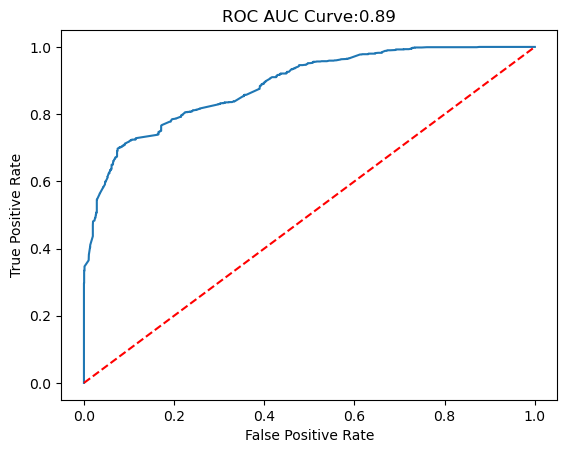

In [409]:
ypred_xgb_s,ypred_xgb_h = model_training(model_xgb)
model_scores(ypred_xgb_h,ypred_xgb_s)
# test score


Confusion Matrix:
 [[16473  1763]
 [ 2146  6711]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.90      0.89     18236
           1       0.79      0.76      0.77      8857

    accuracy                           0.86     27093
   macro avg       0.84      0.83      0.83     27093
weighted avg       0.85      0.86      0.85     27093



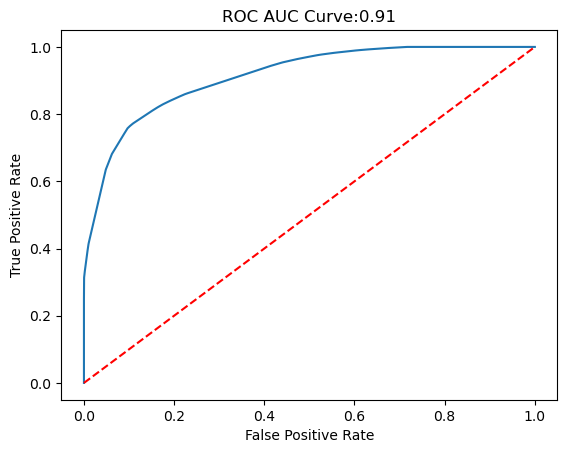

In [410]:
# Decision Tree
# train score
model_dt = DecisionTreeClassifier(max_depth=7)
ypred_dt_s,ypred_dt_h = model_training(model_dt,xtest=x_train)
model_scores(ypred_dt_h,ypred_dt_s,ytest=y_train)


Confusion Matrix:
 [[2144  239]
 [ 422  778]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87      2383
           1       0.76      0.65      0.70      1200

    accuracy                           0.82      3583
   macro avg       0.80      0.77      0.78      3583
weighted avg       0.81      0.82      0.81      3583



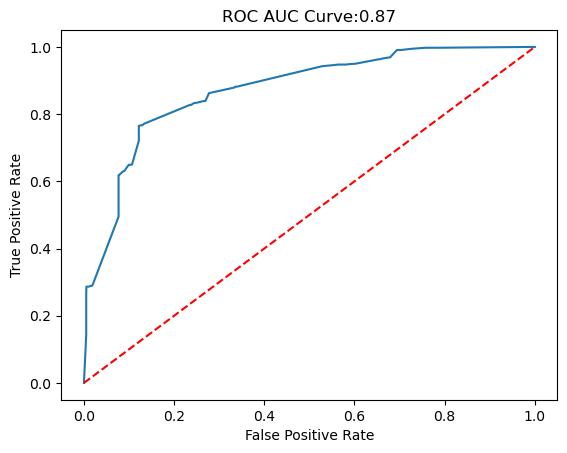

In [411]:

ypred_dt_s,ypred_dt_h = model_training(model_dt)
model_scores(ypred_dt_h,ypred_dt_s)
# Test data

In [ ]:
# Voting model in order to combine both the models since both are not varied in their roc score.
from sklearn.ensemble import VotingClassifier

In [419]:
model_vote = VotingClassifier(estimators=[('DT',model_dt),('XGB',model_xgb)],voting='soft')

In [420]:
model_vote.fit(x_train,y_train)

VotingClassifier(estimators=[('DT', DecisionTreeClassifier(max_depth=7)),
                             ('XGB',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.01, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None, ...))],
                 voting='soft')

In [422]:
ypred_vote_s = model_vote.predict_proba(x_test)[:,1]

In [426]:

ypred_vote_h = (ypred_vote_s>0.3).astype(int)

In [425]:
fpr,tpr,thresholds = roc_curve(y_test,ypred_vote_s)
pd.DataFrame({'FPR':fpr,'TPR':tpr,'Thresholds':thresholds,'YODENS INDEX':tpr*(1-fpr)}).sort_values(by='YODENS INDEX',ascending=False).head(2)  

,FPR,TPR,Thresholds,YODENS INDEX
225,0.154008,0.789167,0.294319,0.667629
224,0.152749,0.787500,0.295261,0.667210



Confusion Matrix:
 [[2022  361]
 [ 263  937]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.85      0.87      2383
           1       0.72      0.78      0.75      1200

    accuracy                           0.83      3583
   macro avg       0.80      0.81      0.81      3583
weighted avg       0.83      0.83      0.83      3583



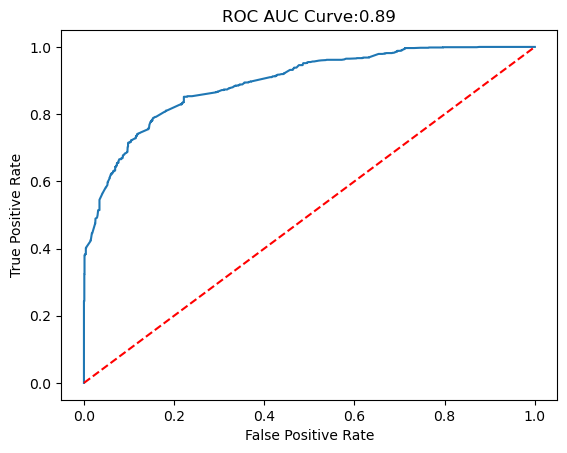

In [427]:
model_scores(ypred_vote_h,ypred_vote_s)

In [428]:
# Deployment
lt = 15
spcl = 0
price = 120
adul = 2
wkend = 2
park = 0
wk = 1
mrkt = 1
amnth = 10
awk = 3
tn = 3
dw = 5

In [429]:
# since this is the raw input data, we have to use antitransform
lt_t,price_t = transformer.transform([[lt,price]])[0]
lt_t,price_t

(4.029223743671129, 84.53117877205352)

In [430]:
input_list = [lt_t,spcl,price_t,adul,wkend,park,wk,mrkt,amnth,awk,tn,dw]

In [431]:
model_vote.predict_proba([input_list])[:,1]

array([0.1300378])

In [432]:
# so there is 0.13 probability that this booking will be cancelled.
# we need all these above instances for deployments. lets create joblib files.
import joblib

In [433]:
with open('transformer_joblib','wb') as file:
    joblib.dump(transformer,file)

In [434]:
with open('final_model.joblib','wb') as file:
    joblib.dump(model_vote,file)